In [1]:
%pylab inline
import matplotlib.pyplot  as plt
import sys,os
import numpy
import glob
import seaborn as sbn
sbn.set_style("whitegrid")
import gzip
import pickle
import pandas as pd
import mdtraj as md
import pip
import itertools
#import pytraj as pt
from rdkit import Chem
from rdkit.Chem import rdFMCS, MCS
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDLogger
import logging
import csv
#import mdshare
import pyemma
import msmtools
# for visualization of molecular structures:
#import nglview
#from nglview.player import TrajectoryPlayer
from pyemma.util.contexts import settings

Populating the interactive namespace from numpy and matplotlib


/Users/mpapadourakis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  app.launch_new_instance()
/Users/mpapadourakis/anaconda3/lib/python3.7/site-packages/pyemma/_ext/orderedset/__init__.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from ._orderedset import OrderedSet


In [2]:
#Loading data from the 20us. For the other force-fields load the appropriate centered trajectories
pdb = md.load('/Volumes/Untitled/cMyc_Edinburgh/amberidp/output_41/amberidp.gro')
#files = ['/home/michalis/c_Myc/Heller_402-412_F4/output/traj_all.dcd']
files = glob.glob('/Volumes/Untitled/cMyc_Edinburgh/amberidp/output_*/centered.cattraj.xtc')

In [3]:
short_dist_feat = pyemma.coordinates.featurizer(pdb)
n_res = 11 # number of residues
F4_ind = 1 # benzamidine index (with residues starting at 1)
ind_arr = np.zeros((n_res,2))
for i in range(n_res):
    ind_arr[i][0] = F4_ind-1
    ind_arr[i][1] = i+1
short_dist_feat.add(residue_pairs=ind_arr, scheme='closest-heavy', threshold=0.4)

short_dist_data = pyemma.coordinates.load(files, features=short_dist_feat)

short_dist_feat.describe()

AttributeError: 'MDFeaturizer' object has no attribute 'add'

In [ ]:
#first and second metrics (use short_dist instead of two distances to build the appropriate MSM)
selection_ca = short_dist_feat.select_Ca()
selection_N = short_dist_feat.select("resname 'LIG' and type 'N'")

ind_arr = np.zeros((n_res,2))
for i in range(n_res):
    ind_arr[i][0] =selection_ca[i]
    ind_arr[i][1] = selection_N[0]

short_dist_feat.add_distances(ind_arr.astype('int64'), periodic=True)
short_dist_feat.describe()

short_dist_data = pyemma.coordinates.load(files, features=short_dist_feat)

In [4]:
#third metric
two_dist_feat = pyemma.coordinates.featurizer(pdb)
selection_ca = two_dist_feat.select_Ca()
selection_2_distances = two_dist_feat.select("resname 'LIG' and index 0 or resname 'LIG' and type 'N'")
selection_2_distances

array([0, 5])

In [8]:
#I must change the selection to update ind_arr_2_distances first with 0 and then with 1
ind_arr_2_distances = np.zeros((n_res,2))
for i in range(n_res):
    ind_arr_2_distances[i][0] =selection_ca[i]
    ind_arr_2_distances[i][1] = selection_2_distances[0]

In [9]:
two_dist_feat.add_distances(ind_arr_2_distances.astype('int64'), periodic=True)
two_dist_feat.describe()

['DIST: TYR 1 CA 31 - LIG 12 N6 5',
 'DIST: ILE 2 CA 52 - LIG 12 N6 5',
 'DIST: LEU 3 CA 71 - LIG 12 N6 5',
 'DIST: SER 4 CA 90 - LIG 12 N6 5',
 'DIST: VAL 5 CA 101 - LIG 12 N6 5',
 'DIST: GLN 6 CA 117 - LIG 12 N6 5',
 'DIST: ALA 7 CA 134 - LIG 12 N6 5',
 'DIST: GLU 8 CA 144 - LIG 12 N6 5',
 'DIST: GLU 9 CA 159 - LIG 12 N6 5',
 'DIST: GLN 10 CA 174 - LIG 12 N6 5',
 'DIST: LYS 11 CA 191 - LIG 12 N6 5',
 'DIST: TYR 1 CA 31 - LIG 12 C1 0',
 'DIST: ILE 2 CA 52 - LIG 12 C1 0',
 'DIST: LEU 3 CA 71 - LIG 12 C1 0',
 'DIST: SER 4 CA 90 - LIG 12 C1 0',
 'DIST: VAL 5 CA 101 - LIG 12 C1 0',
 'DIST: GLN 6 CA 117 - LIG 12 C1 0',
 'DIST: ALA 7 CA 134 - LIG 12 C1 0',
 'DIST: GLU 8 CA 144 - LIG 12 C1 0',
 'DIST: GLU 9 CA 159 - LIG 12 C1 0',
 'DIST: GLN 10 CA 174 - LIG 12 C1 0',
 'DIST: LYS 11 CA 191 - LIG 12 C1 0']

In [10]:
two_dist_data = pyemma.coordinates.load(files, features=two_dist_feat)
np.shape(two_dist_data)

(20, 100010, 22)

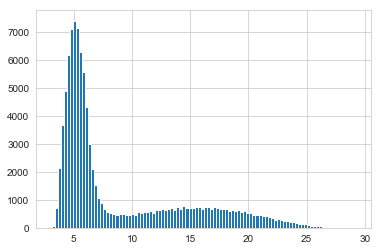

In [11]:
#plot(new_data[0])

shortest_dist_two_dist = []
for traj in two_dist_data:
    new_traj_two_dist = [] # you need every time to refresh your list
    for snapshot in traj:
        new_traj_two_dist.append(min(snapshot)*10) # we are taking the minimum distance every time (multiplied by 10 to convert ns to A)
    shortest_dist_two_dist.append(np.array(new_traj_two_dist)) # saved as np array
    #first_dims.append(item[0])
#len(first_dims)
#len(new_data)
fig = plt.hist(shortest_dist_two_dist[9], bins=100)

# First metric

In [ ]:
short_dist_tica = pyemma.coordinates.tica(short_dist_data, lag=50, units='ps' )
short_dist_tica_output = short_dist_tica.get_output()
print(short_dist_tica_output)
short_dist_tica_concatenated = np.concatenate(short_dist_tica_output)

short_dist_tica.dimension()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    short_dist_tica_concatenated, ['IC {}'.format(i + 1) for i in range(short_dist_tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*short_dist_tica_concatenated.T[0:2], ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*short_dist_tica_concatenated.T[0:2], ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

In [ ]:
#clustering for the tica output
short_dist_cluster_tica = pyemma.coordinates.cluster_kmeans(
    short_dist_tica_output, k=75, max_iter=100, stride=1, fixed_seed=1)
short_dist_dtrajs_concatenated = np.concatenate(short_dist_cluster_tica.dtrajs)

#implied timescales for tica

#pyemma.plots.plot_implied_timescales(its, units='ps', dt=0.1);

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    np.concatenate(short_dist_tica_output), ax=axes[0])
pyemma.plots.plot_density(*short_dist_tica_concatenated.T[0:2], ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*short_dist_cluster_tica.clustercenters.T[:2], s=15, c='C1')
axes[1].set_xlabel('$IC1$')
axes[1].set_ylabel('$IC2$')
pyemma.plots.plot_implied_timescales(short_dist_its, ax=axes[2], units='ps', ylog=False)
fig.tight_layout()

In [ ]:
short_dist_its = pyemma.msm.its(short_dist_cluster_tica.dtrajs, lags=200, nits=10)
pyemma.plots.plot_implied_timescales(short_dist_its, units='ps', dt=10);
plt.savefig("ITS_amberidp_all_distances.png",dpi=600,transparent=True, bbox_inches='tight')

In [ ]:
#msm markov model estimation
short_dist_msm_tica = pyemma.msm.bayesian_markov_model(short_dist_cluster_tica.dtrajs, lag=50, dt_traj='10 ps')
print('fraction of states used = {:.2f}'.format(short_dist_msm_tica.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(short_dist_msm_tica.active_count_fraction))

In [ ]:
# Chapman-Kolmogorov test
#Should a CK test fail, it means that the dynamics in the space of metastable states is not Markovian.
#A failing CK test might further hint at poor sampling.
pyemma.plots.plot_cktest(two_dist_msm.cktest(2), units='ps', y01=False, padding_top=0.08);
#as we can see 4 metastable states is a good number of states
plt.savefig("CK_amberidp_all_distances.png",dpi=600,transparent=True, bbox_inches='tight')

In [ ]:
#If there were any disconnectivities in our data (fractions <1), we could access the indices of the active states (members of the largest connected set) via the active_set attribute
print(short_dist_msm_tica.active_set)

#With this potential issue out of the way, we can extract our first (stationary/thermodynamic) property, the stationary_distribution or, as a shortcut, pi:
print(short_dist_msm_tica.stationary_distribution)
print('sum of weights = {:f}'.format(short_dist_msm_tica.pi.sum()))

#first eigenvector must be 1
short_dist_eigvec = short_dist_msm_tica.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(short_dist_eigvec[:, 0], 1, atol=1e-15), short_dist_eigvec[:, 0].min(), short_dist_eigvec[:, 0].max()))

In [ ]:
# We perform PCCA++ with this number of states for further analysis and print out the stationary probabilities of the metastable sets:
nstates = 2
short_dist_msm_tica.pcca(nstates)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *short_dist_tica_concatenated.T[:2],
        short_dist_msm_tica.metastable_distributions[i][short_dist_dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('$\Phi$')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

In [ ]:
for i, s in enumerate(short_dist_msm_tica.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, short_dist_msm_tica.pi[s].sum()))
    
short_dist_mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        short_dist_mfpt[i, j] = short_dist_msm_tica.mfpt(
            short_dist_msm_tica.metastable_sets[i],
            short_dist_msm_tica.metastable_sets[j])

short_dist_inverse_mfpt = np.zeros_like(short_dist_mfpt)
short_dist_nz = short_dist_mfpt.nonzero()
short_dist_inverse_mfpt[short_dist_nz] = 1.0 / short_dist_mfpt[short_dist_nz]

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(short_dist_mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

In [ ]:
short_dist_metastable_traj = short_dist_msm_tica.metastable_assignments[short_dist_dtrajs_concatenated]
short_dist_highest_membership = short_dist_msm_tica.metastable_distributions.argmax(1)
short_dist_coarse_state_centers = short_dist_cluster_tica.clustercenters[short_dist_msm_tica.active_set[short_dist_highest_membership]]


In [ ]:
#We assume based on the diagram that the bound state is the second one, because we have fewer populations
metastability = short_dist_msm_tica.pcca(2)

#These are the indexes of the second population
indexes = metastability.metastable_sets

#Loop to calculate the average free energy of the unbound states(by using -kT log(stationary distribution))
k = 0.0019872041
T = 298.15
unbound_pis = []
for x in metastability.metastable_sets[0]:
    unbound_pis.append(two_dist_msm.stationary_distribution[x])
    #print(short_dist_msm_tica.stationary_distribution[x])    
    #overal_free_energy_unbound = -k*T*np.unbound_pis

free_energy_unbound = -k*T*np.log(unbound_pis)
average_unbound = np.mean(free_energy_unbound)
print(average_unbound)

#Find the ratio of each bound state versus the overall of the unbound energy
bound_states = []
free_energy_bound_states = []
for i in metastability.metastable_sets[1]:
    bound_states.append(two_dist_msm.stationary_distribution[i])

free_energy_bound_states = -k*T*np.log(bound_states)
average_bound = np.mean(free_energy_bound_states)
#ratio_bound_unbound = free_energy_bound_states / free_energy_unbound
print(average_bound)


overall_unbound = np.sum(unbound_pis)
print(overall_unbound)
overall_bound = np.sum(bound_states)
print(overall_bound)
ratio = -k*T*np.log(overall_bound / overall_unbound)
ratio

# Second metric

In [ ]:
#plot(new_data[0])

shortest_dist = []
for traj in short_dist_data:
    new_traj = [] # you need every time to refresh your list
    for snapshot in traj:
        new_traj.append(min(snapshot)*10) # we are taking the minimum distance every time (multiplied by 10 to convert ns to A)
    shortest_dist.append(np.array(new_traj)) # saved as np array
    #first_dims.append(item[0])

In [ ]:
#clustering for the tica output
short_dist_cluster = pyemma.coordinates.cluster_kmeans(
    shortest_dist, k=75, stride=1, fixed_seed=0)

#mplied timescales for tica
short_dist_its = pyemma.msm.its(short_dist_cluster.dtrajs, lags=200, nits=10)
pyemma.plots.plot_implied_timescales(short_dist_its, units='ps', dt=10);
plt.savefig("ITS_amberidp_shortest_distance.png",dpi=600,transparent=True, bbox_inches='tight')

#msm markov model estimation
short_dist_msm_tica = pyemma.msm.bayesian_markov_model(short_dist_cluster.dtrajs, lag=200, dt_traj='10 ps')
print('fraction of states used = {:.2f}'.format(short_dist_msm_tica.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(short_dist_msm_tica.active_count_fraction))

#Chapman-Kolmogorov test
#Should a CK test fail, it means that the dynamics in the space of metastable states is not Markovian.
#A failing CK test might further hint at poor sampling.
pyemma.plots.plot_cktest(short_dist_msm_tica.cktest(2), units='ps', y01=False, padding_top=0.08);
#as we can see 4 metastable states is a good number of states
plt.savefig("CK_amberidp_shortest_distance.png",dpi=600,transparent=True, bbox_inches='tight')

#If there were any disconnectivities in our data (fractions <1), we could access the indices of the active states (members of the largest connected set) via the active_set attribute
print(short_dist_msm_tica.active_set)

#With this potential issue out of the way, we can extract our first (stationary/thermodynamic) property, the stationary_distribution or, as a shortcut, pi:
print(short_dist_msm_tica.stationary_distribution)
print('sum of weights = {:f}'.format(short_dist_msm_tica.pi.sum()))

#first eigenvector must be 1
short_dist_eigvec = short_dist_msm_tica.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(short_dist_eigvec[:, 0], 1, atol=1e-15), short_dist_eigvec[:, 0].min(), short_dist_eigvec[:, 0].max()))

In [ ]:
# We perform PCCA++ with this number of states for further analysis and print out the stationary probabilities of the metastable sets:
nstates = 2
short_dist_msm_tica.pcca(nstates)

for i, s in enumerate(short_dist_msm_tica.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, short_dist_msm_tica.pi[s].sum()))
    
short_dist_mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        short_dist_mfpt[i, j] = short_dist_msm_tica.mfpt(
            short_dist_msm_tica.metastable_sets[i],
            short_dist_msm_tica.metastable_sets[j])

short_dist_inverse_mfpt = np.zeros_like(short_dist_mfpt)
short_dist_nz = short_dist_mfpt.nonzero()
short_dist_inverse_mfpt[short_dist_nz] = 1.0 / short_dist_mfpt[short_dist_nz]

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(short_dist_mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

In [ ]:
#We assume based on the diagram that the bound state is the second one, because we have fewer populations
metastability = short_dist_msm.pcca(2)
print(metastability)

#These are the indexes of the second population
indexes = metastability.metastable_sets

In [ ]:
#Loop to calculate the average free energy of the unbound states(by using -kT log(stationary distribution))
k = 0.0019872041
T = 298.15
unbound_pis = []
for x in metastability.metastable_sets[0]:
    unbound_pis.append(short_dist_msm.stationary_distribution[x])
    #print(short_dist_msm_tica.stationary_distribution[x])    
    #overal_free_energy_unbound = -k*T*np.unbound_pis

free_energy_unbound = -k*T*np.log(unbound_pis)
average_unbound = np.mean(free_energy_unbound)
print(average_unbound)

#Find the ratio of each bound state versus the overall of the unbound energy
bound_states = []
free_energy_bound_states = []
for i in metastability.metastable_sets[1]:
    bound_states.append(short_dist_msm.stationary_distribution[i])

free_energy_bound_states = -k*T*np.log(bound_states)
average_bound = np.mean(free_energy_bound_states)
#ratio_bound_unbound = free_energy_bound_states / free_energy_unbound
print(average_bound)


overall_unbound = np.sum(unbound_pis)
print(overall_unbound)
overall_bound = np.sum(bound_states)
print(overall_bound)
ratio = -k*T*np.log(overall_bound / overall_unbound)
ratio

In [ ]:
bound = []
unbound = []
cc = short_dist_cluster.clustercenters
for i in range(len(short_dist_msm.metastable_assignments)):
    if short_dist_msm.metastable_assignments[i] == 1:
        unbound.append(cc[i])
    else:
        bound.append(cc[i])

        
print(max(bound))
print(min(unbound))

In [ ]:
pcca_samples = short_dist_msm.sample_by_state(50, subset = C)
short_dist = pyemma.coordinates.source(files, features=short_dist_feat)
print(pcca_samples)
pyemma.coordinates.save_trajs(
    short_dist,
    pcca_samples,
    prefix = 'amberidp_short_dist_1000_snapshots',
    fmt = 'dcd')

# Third metric

26-06-24 03:06:31 pyemma.coordinates.clustering.kmeans.KmeansClustering[21] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


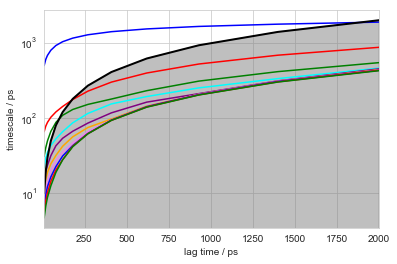

In [37]:
two_dist_cluster = pyemma.coordinates.cluster_kmeans(
    shortest_dist_two_dist, k=75, stride=1, fixed_seed=0)

#mplied timescales for tica
two_dist_its = pyemma.msm.its(two_dist_cluster.dtrajs, lags=200, nits=10)
pyemma.plots.plot_implied_timescales(two_dist_its, units='ps', dt=10);
plt.savefig("ITS_amberidp_2_distances.png",dpi=600,transparent=True, bbox_inches='tight')

In [38]:
#msm markov model estimation
two_dist_msm = pyemma.msm.bayesian_markov_model(two_dist_cluster.dtrajs, lag=200, dt_traj='10 ps')
print('fraction of states used = {:.2f}'.format(two_dist_msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(two_dist_msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


In [14]:
#Chapman-Kolmogorov test
#Should a CK test fail, it means that the dynamics in the space of metastable states is not Markovian.
#A failing CK test might further hint at poor sampling.
pyemma.plots.plot_cktest(two_dist_msm.cktest(2), units='ps', y01=False, padding_top=0.08);
#as we can see 4 metastable states is a good number of states
plt.savefig("CK_amberidp_2_distances.png",dpi=600,transparent=True, bbox_inches='tight')

KeyboardInterrupt: 

In [39]:
#If there were any disconnectivities in our data (fractions <1), we could access the indices of the active states (members of the largest connected set) via the active_set attribute
print(two_dist_msm.active_set)

#With this potential issue out of the way, we can extract our first (stationary/thermodynamic) property, the stationary_distribution or, as a shortcut, pi:
print(two_dist_msm.stationary_distribution)
print('sum of weights = {:f}'.format(two_dist_msm.pi.sum()))

#first eigenvector must be 1
two_dist_eigvec = two_dist_msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(two_dist_eigvec[:, 0], 1, atol=1e-15), two_dist_eigvec[:, 0].min(), two_dist_eigvec[:, 0].max()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74]
[0.01754598 0.12560194 0.00392285 0.14966628 0.00203426 0.00404382
 0.00757537 0.01840615 0.16170074 0.0136713  0.01452644 0.00265395
 0.00548046 0.01736068 0.00503045 0.10647238 0.0026222  0.07429994
 0.00197012 0.00312544 0.00421226 0.00317844 0.03711253 0.00503466
 0.00190248 0.00284991 0.00180116 0.00252176 0.00356527 0.00175305
 0.00251893 0.002066   0.00157221 0.00447781 0.00570729 0.00330637
 0.00748844 0.00247786 0.00290861 0.00353193 0.00278577 0.00298288
 0.00244829 0.01142163 0.00290747 0.00255054 0.00276556 0.00459651
 0.0028732  0.0091637  0.00588292 0.00410271 0.00284941 0.00242504
 0.01571943 0.00487601 0.0031033  0.00433197 0.00296905 0.00406695
 0.00195512 0.01069081 0.00455046 0.00348313 0.00226756 0.0070263
 0.00163476 0.00511351 0.00408771 

In [40]:
# We perform PCCA++ with this number of states for further analysis and print out the stationary probabilities of the metastable sets:
nstates = 2
two_dist_msm.pcca(nstates)

for i, s in enumerate(two_dist_msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, two_dist_msm.pi[s].sum()))
    
two_dist_mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        two_dist_mfpt[i, j] = two_dist_msm.mfpt(
            two_dist_msm.metastable_sets[i],
            two_dist_msm.metastable_sets[j])

two_dist_inverse_mfpt = np.zeros_like(two_dist_mfpt)
two_dist_nz = two_dist_mfpt.nonzero()
two_dist_inverse_mfpt[two_dist_nz] = 1.0 / two_dist_mfpt[two_dist_nz]

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(two_dist_mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

π_1 = 0.345146
π_2 = 0.654854
MFPT / steps:


,1,2
1,0.00,4488.22
2,8544.69,0.00


In [41]:
bound = []
unbound = []
cc = two_dist_cluster.clustercenters
for i in range(len(two_dist_msm.metastable_assignments)):
    if two_dist_msm.metastable_assignments[i] == 0:
        unbound.append(cc[i])
    else:
        bound.append(cc[i])

        
print(max(bound))
print(min(unbound))

[6.9103465]
[7.574901]


In [42]:
#We assume based on the diagram that the bound state is the second one, because we have fewer populations
metastability = two_dist_msm.pcca(2)
print(metastability)

#These are the indexes of the second population
indexes = metastability.metastable_sets
indexes

PCCA(P=array([[0.03555, 0.0837 , ..., 0.00951, 0.00893],
       [0.01169, 0.16609, ..., 0.00397, 0.00409],
       ...,
       [0.0294 , 0.08777, ..., 0.00813, 0.00781],
       [0.02763, 0.0905 , ..., 0.00781, 0.01061]]),
   m=2)


[array([ 0,  2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74]), array([ 1,  3,  8, 15, 17, 22])]

In [43]:
#Loop to calculate the average free energy of the unbound states(by using -kT log(stationary distribution))
k = 0.0019872041
T = 298.15
unbound_pis = []
for x in metastability.metastable_sets[0]:
    unbound_pis.append(two_dist_msm.stationary_distribution[x])
    #print(short_dist_msm_tica.stationary_distribution[x])    
    #overal_free_energy_unbound = -k*T*np.unbound_pis

free_energy_unbound = -k*T*np.log(unbound_pis)
average_unbound = np.mean(free_energy_unbound)
print(average_unbound)

#Find the ratio of each bound state versus the overall of the unbound energy
bound_states = []
free_energy_bound_states = []
for i in metastability.metastable_sets[1]:
    bound_states.append(two_dist_msm.stationary_distribution[i])

free_energy_bound_states = -k*T*np.log(bound_states)
average_bound = np.mean(free_energy_bound_states)
#ratio_bound_unbound = free_energy_bound_states / free_energy_unbound
print(average_bound)


overall_unbound = np.sum(unbound_pis)
print(overall_unbound)
overall_bound = np.sum(bound_states)
print(overall_bound)
ratio = -k*T*np.log(overall_bound / overall_unbound)
ratio

3.2665806337585783
1.3754841217660758
0.3451461804450261
0.6548538195549737


-0.37945339832415287

In [44]:
#My way to pick the most populates states
B = two_dist_msm.metastable_assignments
print(B)
C = []
for i in range(len(two_dist_msm.metastable_assignments)):
    if two_dist_msm.metastable_assignments[i] == 1:
        C.append(two_dist_msm.metastable_assignments[i])
print(len(C))

[0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
6


In [38]:
pcca_samples = two_dist_msm.sample_by_state(1, subset = C)
short_dist = pyemma.coordinates.source(files, features=two_dist_feat)
print(pcca_samples)
pyemma.coordinates.save_trajs(
    short_dist,
    pcca_samples,
    prefix = 'amberidp_two_dist_1000_snapshots_vol1',
    fmt = 'pdb')

[array([[   11, 43375]]) array([[    6, 49793]]) array([[   16, 54960]])
 array([[   13, 16911]]) array([[   8, 4413]]) array([[   2, 8026]])]


['amberidp_two_dist_1000_snapshots_vol1000000.pdb',
 'amberidp_two_dist_1000_snapshots_vol1000001.pdb',
 'amberidp_two_dist_1000_snapshots_vol1000002.pdb',
 'amberidp_two_dist_1000_snapshots_vol1000003.pdb',
 'amberidp_two_dist_1000_snapshots_vol1000004.pdb',
 'amberidp_two_dist_1000_snapshots_vol1000005.pdb']

In [45]:
#This is a random sampling through the 2 states of the simulation (but we are not taking the most populated samples from each state)
pcca_samples = two_dist_msm.sample_by_distributions(two_dist_msm.metastable_distributions, 1000)
two_dist = pyemma.coordinates.source(files, features=two_dist_feat)
print(pcca_samples)
pyemma.coordinates.save_trajs(
    two_dist,
    pcca_samples,
    outfiles=['two_dist{}_2samples_vol4.xtc'.format(n + 1)
              for n in range(two_dist_msm.n_metastable)])

[array([[   11, 18602],
       [   11, 52990],
       [    7, 54277],
       ...,
       [    1, 69333],
       [   15, 96950],
       [   16, 49331]])
 array([[    8, 24847],
       [    7, 10081],
       [    5, 49049],
       ...,
       [   18, 76844],
       [   13, 53354],
       [    3, 31445]])]


['two_dist1_2samples_vol4.xtc', 'two_dist2_2samples_vol4.xtc']

In [ ]:
#For each metric
#Simulated ligand in artificial free state. The ligand in free state will have standard volume
#So we tend see the transition between bound and unbound. We tend to give much entropy to the ligand
#and that's why we need the free volume instead the bound volume
import numpy as np
k = 0.0019872041
T = 298.15
pi = 3.14159
r = 10.544257
V_sphere = 1.33*pi*r**3
print("the average value of distance C10 to Val6@CA is 11.76 A^3")
print('the volume of the sphere for the ligand is %f A^3' %V_sphere)

Length = 46.9433320
Width = 52.1732500
Height = 43.2221480
Vtotal = Length*Width*Height
print('the average volume of the box is %f A^3' %Vtotal)

Vfree = Vtotal - V_sphere 
print('the unbound volume of the box is %f A^3' %Vfree)

Vstandard = 1660
ratio = -0.11

DGmsm = -ratio - k*T*np.log(V_sphere / Vstandard)
print('the standard binding free energy is %f kcal/mol' %DGmsm)

In [ ]:
#####Calculating transition rates - We need them in second-1 that's we calculate the values by 10^-9

#Calculating the ligand's concentration
Number_of_molecules = 1
NA =  6.022 * 10**23
Vtotal_liters = Vtotal * 10**-27

Conc = Number_of_molecules / (NA * Vtotal_liters)
print('the concentration of the ligand is %f M' %Conc)

#Calculating koff
print('mfpt of unbound to bound is %f' %two_dist_mfpt[0][1])
koff = 1/(two_dist_mfpt[0][1]*10*10**-9)
print(koff)

#Calculating kon
print('mfpt of bound to unbound is %f' %two_dist_mfpt[1][0])
kon = 1/(two_dist_mfpt[1][0]*Conc*10*10**-9)
kon